In diesem Notebook transformieren wir die Spektrogramme (300 pro Klasse, da beschränkter RAM bzw. beschränkte Rechenleistung) mittels PCA in einen niederdimensionalen Raum (1,2,3,5,10,100 Dimensionen). Zuerst werden die Daten in 2 und 3 Dimensionen visualisiert. Anschließend wenden wir verschiedene Verfahren auf die Daten in den Kompressionsräumen an.

In [1]:
# Die Daten befinden sich in der Datenbank. read_data.py stellt eine Funktion read_data bereit, die die Anzahl der Spektrogramme pro Klasse erhält
# und die Daten aus der Datenbank einliest, sklaliert, die STFT durchführt und das Ganze in einen pandas.DataFrame data schreibt. Wichtig sind
# hierbei die Spalten data['arr'], die tatsächlichen Daten und data['target'], die Klassenzugehörigkeit.

import read_data
data = read_data.read_data(300)
print(data.head(5))

/home/lo/pg/ML/ML-Projekt/read_data.py:30: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


    call  target  id             bat  \
0  38818       0   0  Bartfledermaus   
1  46731       0   1  Bartfledermaus   
2  49137       0   2  Bartfledermaus   
3  49557       0   3  Bartfledermaus   
4  22197       0   4  Bartfledermaus   

                                                 arr     db  
0  [[[0.5383580417881516], [0.5394855702323632], ...  skiba  
1  [[[0.570258907583444], [0.5589728547063831], [...  skiba  
2  [[[0.5736033747601932], [0.5694056445135038], ...  skiba  
3  [[[0.5302138933564621], [0.5282555104293256], ...  skiba  
4  [[[0.6601127852592856], [0.6601250353256682], ...  skiba  


In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Die Daten und Targets werden in numpy.Arrays mit den richtigen Shapes geschrieben 

X = np.concatenate(data['arr'].values).reshape(-1, 256*128)
print(X.shape)

y = data['target']
print(y.shape)

(5700, 32768)
(5700,)


Dimensionsreduktion mit PCA und der Anteil der erklärten Varianz für einige Dimensionen

In [4]:
# PCA: Könnte man nur einmal machen und sich die Arrays raus schneiden, aber hier zur Abwechslung mal keine allzu langen Laufzeiten

dims = [1, 2, 3, 5, 10, 100]
X_pca = []

for dim in dims:
    pca = PCA(n_components=dim)
    transformed = pca.fit_transform(X)
    X_pca.append(transformed)
    print(f"{dim} Hauptkomponente(n): {sum(pca.explained_variance_ratio_):.3f} variance explained")

1 Hauptkomponente(n): 0.575 variance explained
2 Hauptkomponente(n): 0.651 variance explained
3 Hauptkomponente(n): 0.699 variance explained
5 Hauptkomponente(n): 0.753 variance explained
10 Hauptkomponente(n): 0.800 variance explained
100 Hauptkomponente(n): 0.881 variance explained


Visualierung der transformierten Daten (2, 3 Dimensionen)

/tmp/ipykernel_3745/4249318831.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
/tmp/ipykernel_3745/4249318831.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c_map = plt.cm.get_cmap('jet', 19)


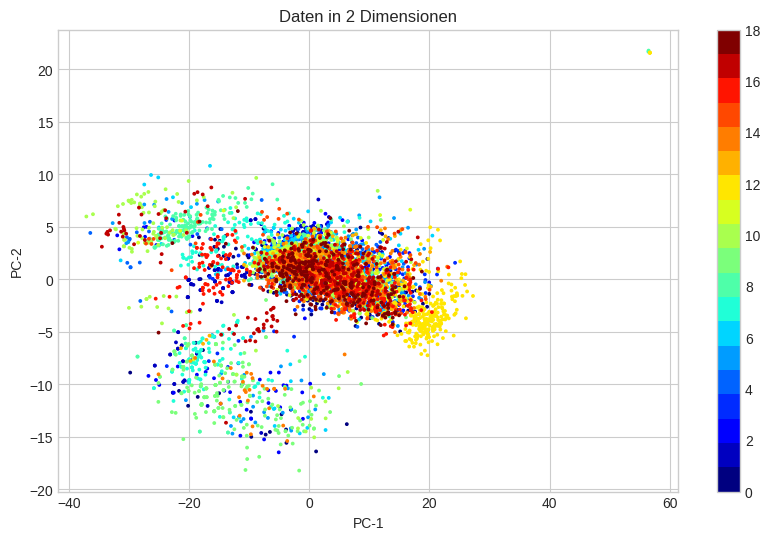

In [5]:
# Plot für 2 Dimensionen

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 19)
plt.scatter(X_pca[1][:, 0], X_pca[1][:, 1], s = 3,
            cmap = c_map , c = y)
plt.colorbar()
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Daten in 2 Dimensionen')
plt.show()

Die Daten in 2 Dimensionen sehen nicht vielversprechend aus. Einige Cluster sind teilweise erkennbar. Die große Überschneidung ist sehr schlecht für die (lineare) Trennbarkeit der Daten. Es gibt zwei markante Ausreißer. Prognose: Ergebnisse werden nicht gut sein

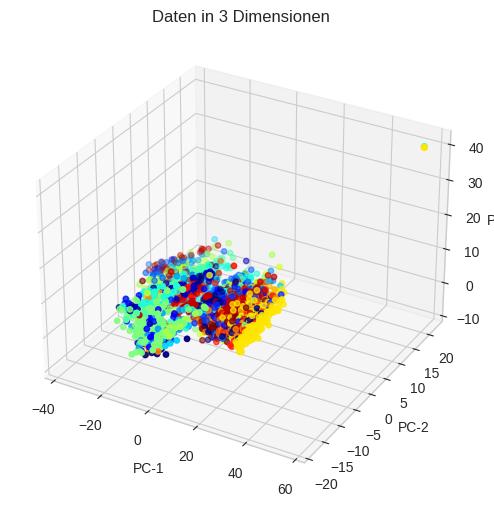

In [6]:
# Statischer Plot in 3 Dimensionen

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_pca[2][:, 0], X_pca[2][:, 1], X_pca[2][:, 2], s = 15,
            cmap = c_map , c = y)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')
ax.set_title('Daten in 3 Dimensionen')

plt.show()

Gleiches gilt für den 3-dimensionalen Kompressionsraum. Separierbarkeit ist schwierig. Vermutung: Ebensfalls schlechte Ergebnisse

In [7]:
# KNN mit k zwischen 1 und 100 auf den transformierten Daten. LLOCV wäre gut, da deterministische Ergebnisse, dauert aber zu lange, deshalb CV 
# mit 5 Splits. Als Ergebnis wird der Durchschnitt der jeweiligen Accuracies verwendet

k = range(1, 101)
scores_knn = []

for i, pca_data in enumerate(X_pca):
    scores_knn.append([])
    for n_neighbors in k:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        scores = cross_validate(knn, pca_data, y)
        scores_knn[i].append(np.mean(scores["test_score"]))

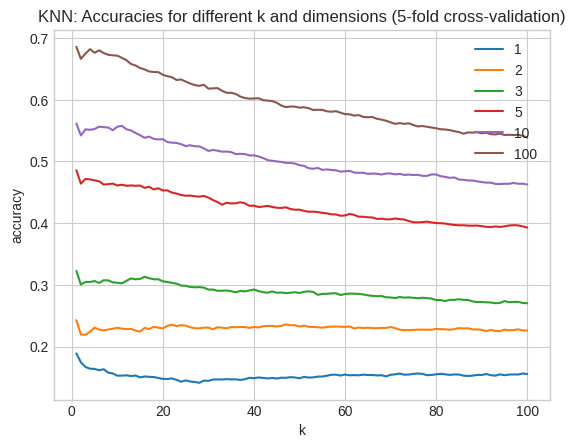

In [8]:
# Visualisierung der Ergebnisse

for elem in scores_knn:
    plt.plot(k, elem, label=dims[scores_knn.index(elem)])
plt.xlabel("k")
plt.ylabel("accuracy")
plt.legend(loc="upper right")
plt.title("KNN: Accuracies for different k and dimensions (5-fold cross-validation)")
plt.show()

Ergebnis von KNN: Mit vielen Dimensionen noch ordentliche Ergebnisse aber im niedrig-dimensionalen Raum nicht mehr praktikabel. Ein kleines k ist tendenziell besser als sehr großes k.

In [9]:
# KLassifikation mit Decision Trees. Für jeden der Kompressionsräume wird getestet, welchen Einfluss die maximale Tiefe und das criterion für die
# Accuracy hat

max_depths = range(1, 11)
criterions_tree = ["gini", "entropy", "log_loss"]

scores_tree = []

for i, pca_data in enumerate(X_pca):
    scores_tree.append([])
    for j, criterion in enumerate(criterions_tree):
        scores_tree[i].append([])
        for max_depth in max_depths:
            tree = DecisionTreeClassifier(criterion=criterion,
                                        max_depth=max_depth)
            scores = cross_validate(tree, pca_data, y)
            scores_tree[i][j].append(np.mean(scores["test_score"]))

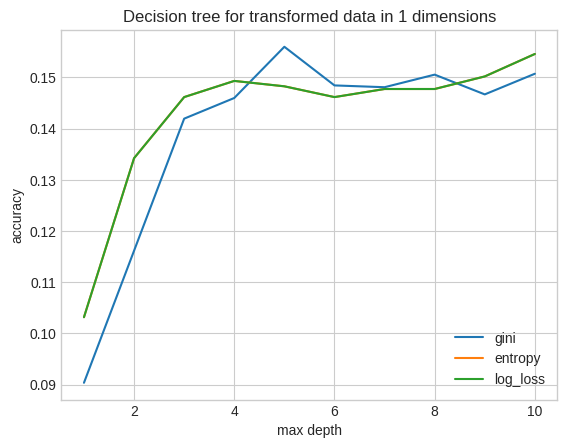

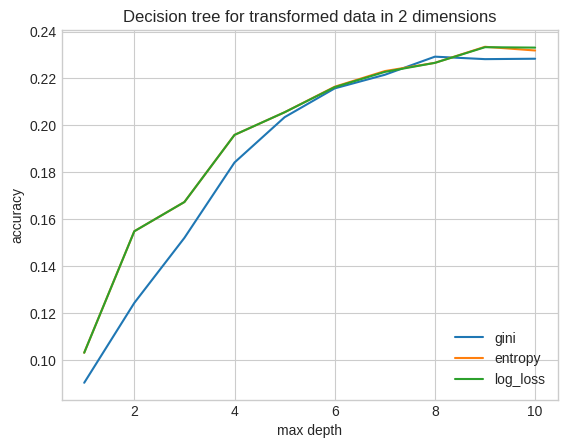

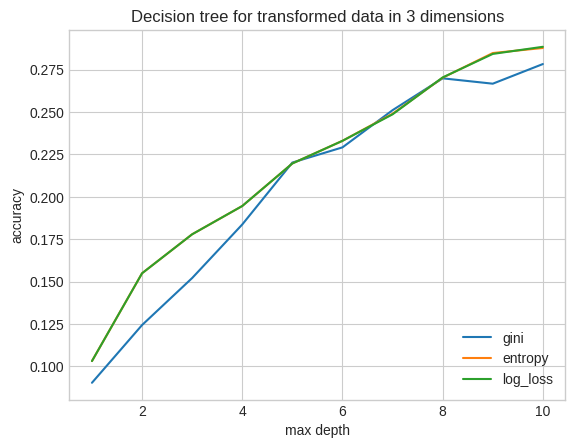

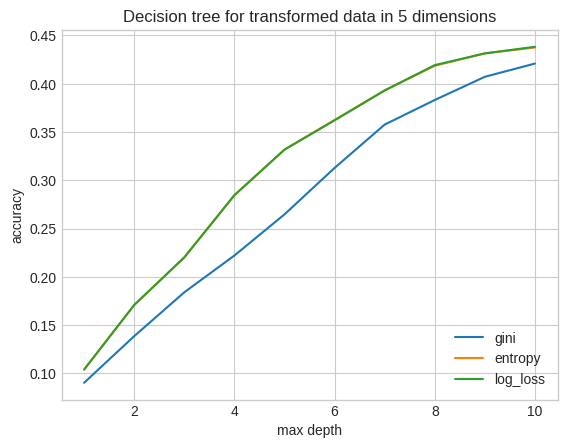

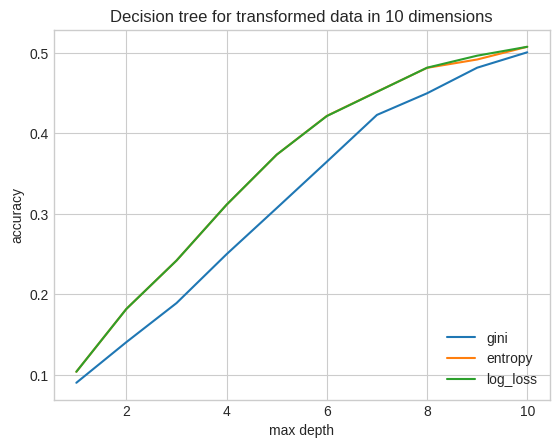

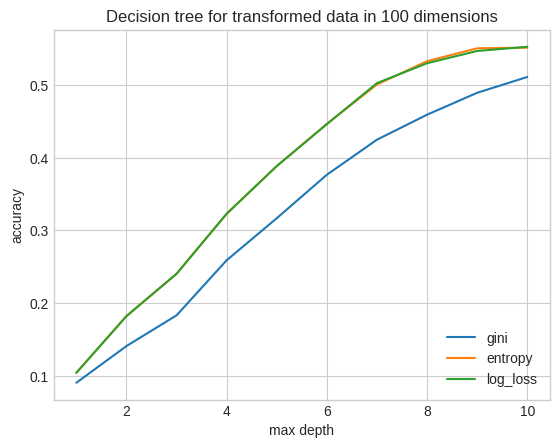

In [10]:
# Visualisierung der Ergebnisse. Für jeden Kompressionsraum ein eigener Graph

for elem in scores_tree: 
    for i, criterion in enumerate(elem):
        plt.plot(max_depths, elem[i], label=criterions_tree[i])
    plt.xlabel("max depth")
    plt.ylabel("accuracy")
    plt.title(f"Decision tree for transformed data in {dims[scores_tree.index(elem)]} dimensions")
    plt.legend(loc="lower right")
    plt.show()

Die criterions entropy und log_loss liefern sehr ähnliche Ergebnisse. Die Ergebnisse sind für wenige Dimensionen erwartbar schlecht. Sogar KNN übertrifft die Bäume in einigen Fällen. Die Prognose bestätigt sich: Schlechte lineare Trennbarkeit der Daten in niedrig-dimensionalen Kompressräumen.

Jetzt verschiedene Ensemble-Verfahren:
1. Random Forest
2. Bagging
3. Extra Random
4. AdaBoost
5. Gradient Boosting

In [11]:
# Random Forest für verschiedene Anzahl an Bäumen und verschiedene criterions

n_estimators_rf = range(20, 220, 20)
criterions_rf = ["gini", "entropy", "log_loss"]

scores_rf = []

for i, pca_data in enumerate(X_pca): # dauert sonst zu lange
    scores_rf.append([])
    for j, criterion in enumerate(criterions_rf):
        scores_rf[i].append([])
        for n_estimator in n_estimators_rf:
            rf = RandomForestClassifier(criterion=criterion,
                                        n_estimators=n_estimator)
            scores = cross_validate(rf, pca_data, y)
            scores_rf[i][j].append(np.mean(scores["test_score"]))

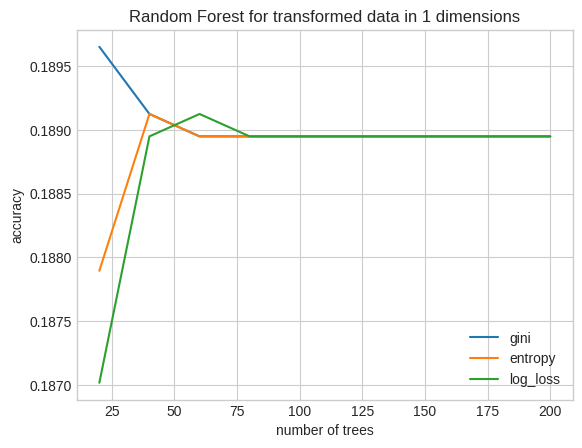

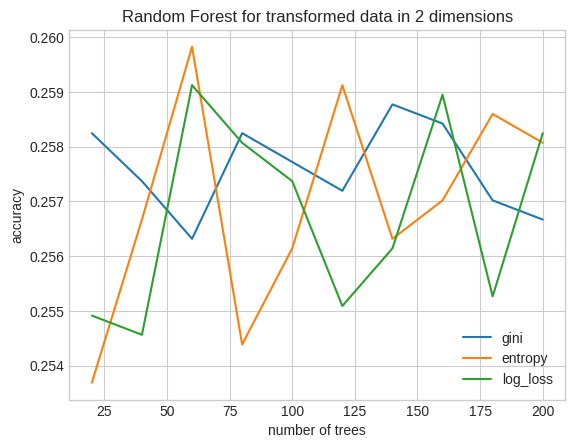

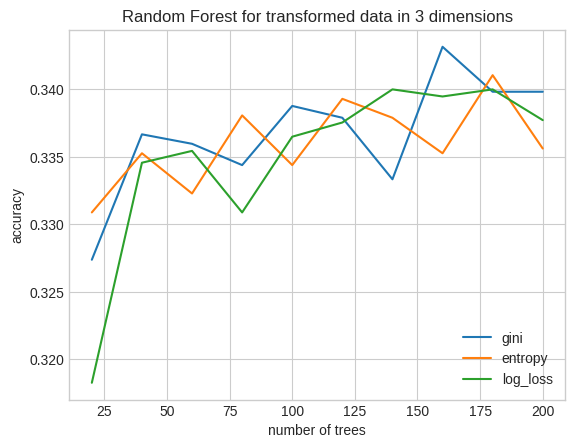

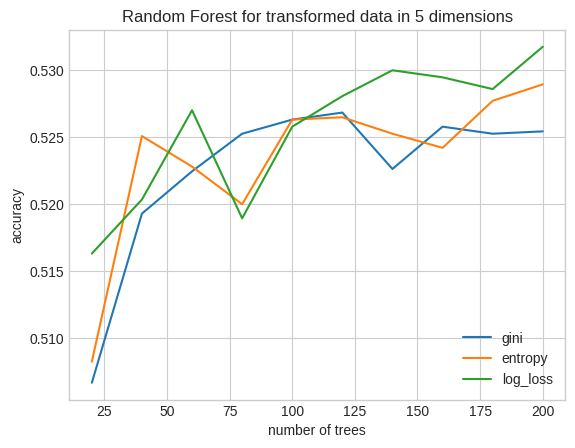

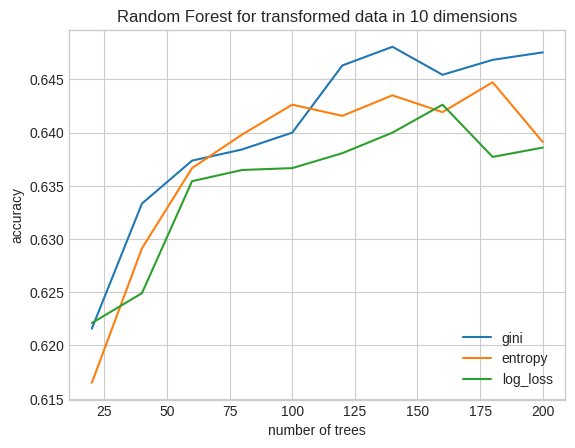

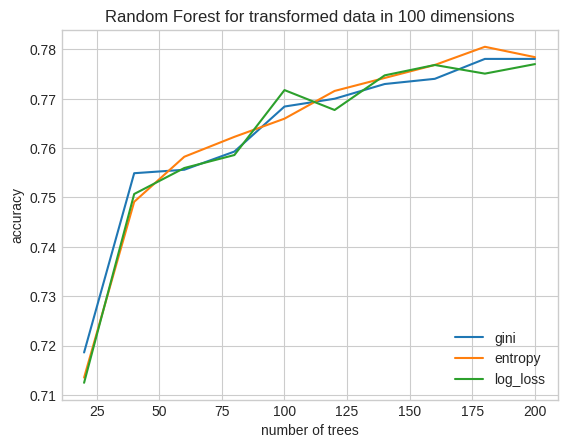

In [12]:
# Hiermit könnte man die Ergebnisse für alle Accuracies plotten. Separater Plot für jede Dimension

for elem in scores_rf: 
    for i, criterion in enumerate(elem):
        plt.plot(n_estimators_rf, elem[i], label=criterions_rf[i])
    plt.xlabel("number of trees")
    plt.ylabel("accuracy")
    plt.title(f"Random Forest for transformed data in {dims[scores_rf.index(elem)]} dimensions")
    plt.legend(loc="lower right")
    plt.show()

Random Forest liefert für die entscheidenden Dimensionen ebensfalls schlechte Ergebnisse. Performt aber besser als der einfach Baum. Mit 100 Dimensionen schon gute Ergebnisse von nahezu 80 %.

In [13]:
# Bagging für verschiedene Anzahl an Bäumen

n_estimators_bagging = range(10, 110, 10)

scores_bagging = []

for i, pca_data in enumerate(X_pca):
    scores_bagging.append([])
    for n_estimator in n_estimators_bagging:
        bagging = BaggingClassifier(n_estimators=n_estimator)
        scores = cross_validate(bagging, pca_data, y)
        scores_bagging[i].append(np.mean(scores["test_score"]))

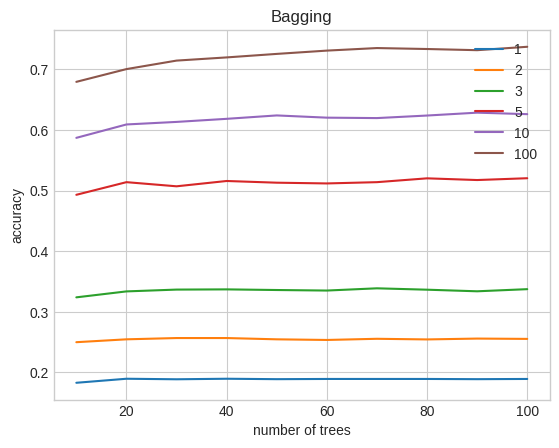

In [14]:
# Ein Plot für alle Dimensionen

for i, elem in enumerate(scores_bagging):
    plt.plot(n_estimators_bagging, elem, label=dims[i])
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.title("Bagging")
plt.legend(loc="upper right")
plt.show()

Auch Bagging liefert nur mit vielen Dimensionen ordentliche Ergebnisse. Vergleichbar mit der Accuracy von Random Forest.

In [15]:
# Extra Trees Classifier (Ähnlich wie Random Forest, aber die Features und Samples werden zufällig ausgewählt) mit verschiedener Anzahl an Bäumen und unterschiedlichen criterions

n_estimators_et = range(20, 220, 20)
criterions_et = ["gini", "entropy", "log_loss"]

scores_et = []

for i, pca_data in enumerate(X_pca):
    scores_et.append([])
    for j, criterion in enumerate(criterions_et):
        scores_et[i].append([])
        for n_estimator in n_estimators_et:
            et = ExtraTreesClassifier(criterion=criterion,
                                    n_estimators=n_estimator)
            scores = cross_validate(et, pca_data, y)
            scores_et[i][j].append(np.mean(scores["test_score"]))

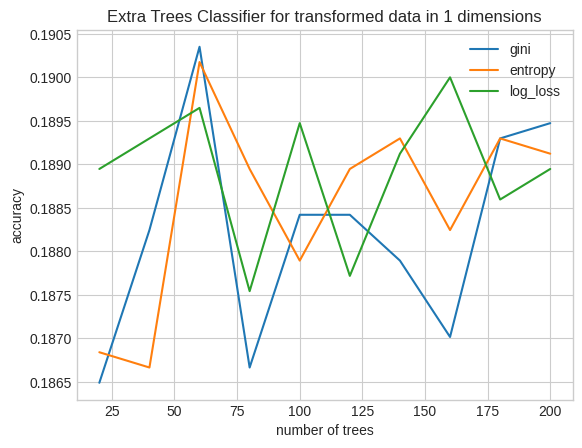

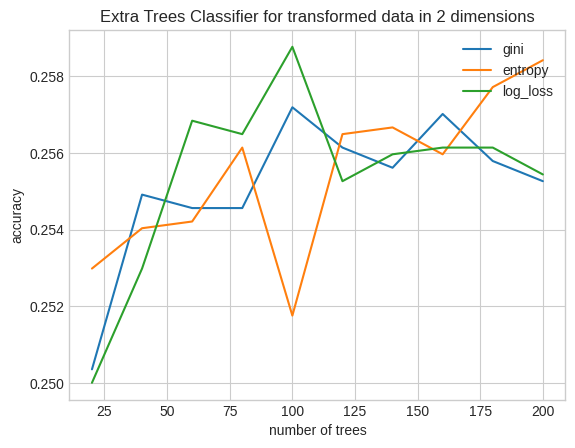

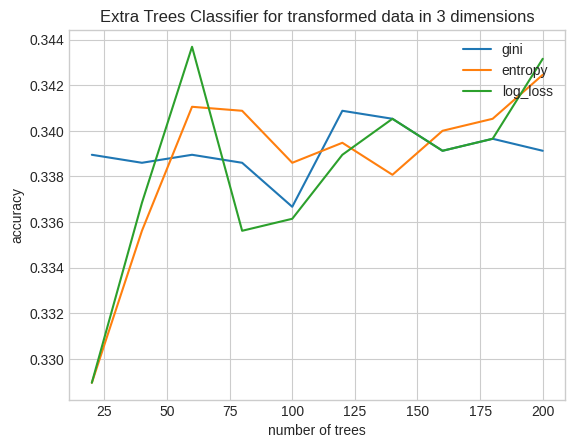

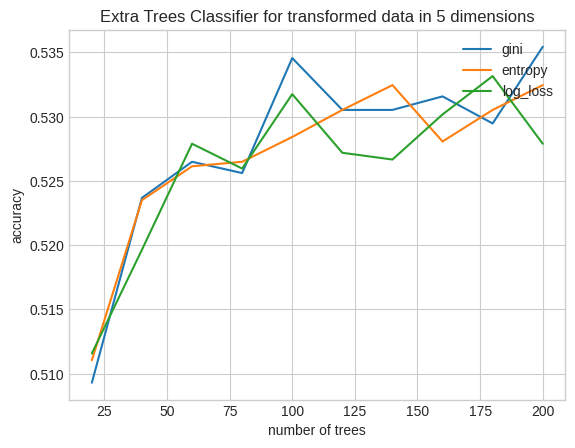

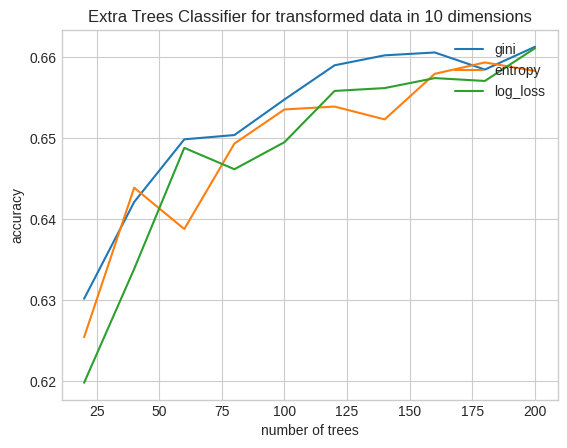

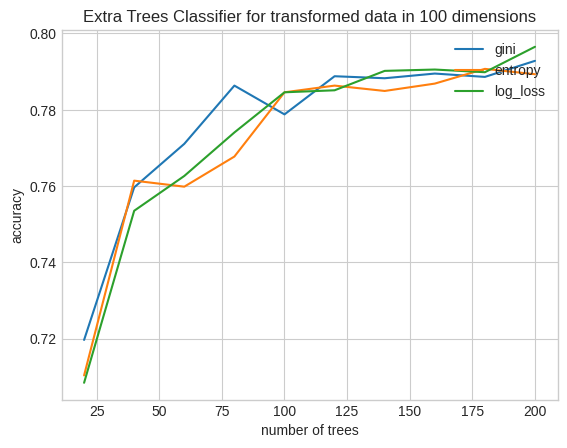

In [16]:
for elem in scores_et: 
    for i, criterion in enumerate(elem):
        plt.plot(n_estimators_et, elem[i], label=criterions_et[i])
    plt.xlabel("number of trees")
    plt.ylabel("accuracy")
    plt.title(f"Extra Trees Classifier for transformed data in {dims[scores_et.index(elem)]} dimensions")
    plt.legend(loc="upper right")
    plt.show()

Auch der Extra Tree Classifier liefert enttäuschende Ergebnisse (in nieder-dimensionalen Kompressionsräumen). Die Genauigkeit ist ähnlich zu den bisherigen Ensemble Verfahren.

In [17]:
# Ada Boosting für verschiedene Lernraten und verschiedener Anzahl an Bäumen

n_estimators_ada = range(20, 220, 20)
learning_rates = np.arange(0.2, 2.2, 0.2)

scores_ada = []

for i, pca_data in enumerate(X_pca):
    scores_ada.append([])
    for j, lr in enumerate(learning_rates):
        scores_ada[i].append([])
        for n_estimator in n_estimators_ada:
            ada = AdaBoostClassifier(learning_rate=lr,
                                    n_estimators=n_estimator)
            scores = cross_validate(ada, pca_data, y)
            scores_ada[i][j].append(np.mean(scores["test_score"]))

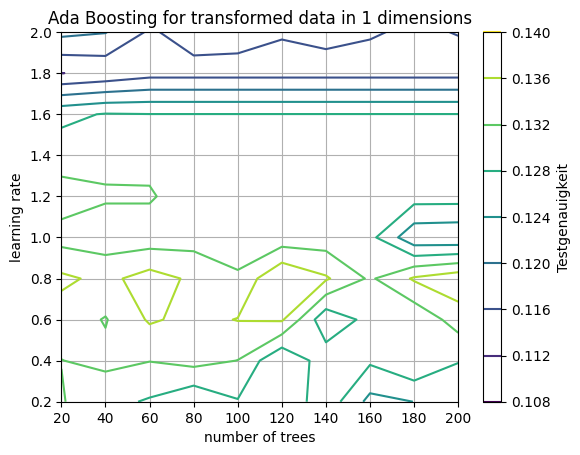

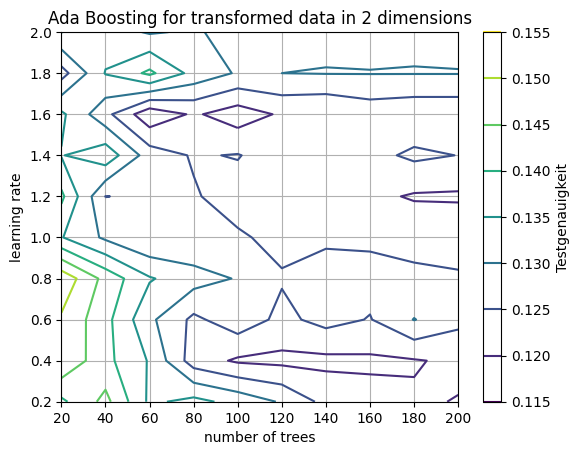

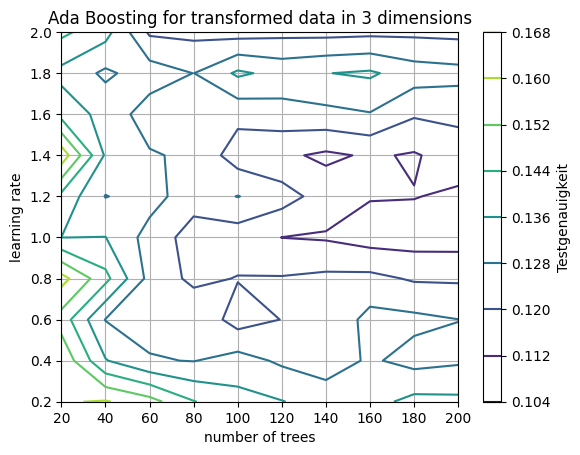

In [ ]:
# Contour-Plots für jede Dimension

for elem in scores_ada:
    C = plt.contour(n_estimators_ada, learning_rates, np.array(elem).reshape(10, 10), cmap='viridis')
    plt.colorbar(C, label='Testgenauigkeit')
    plt.xlabel("number of trees")
    plt.ylabel("learning rate")
    plt.title(f"Ada Boosting for transformed data in {dims[scores_ada.index(elem)]} dimensions")
    plt.xticks(n_estimators_ada)
    plt.yticks(learning_rates)
    plt.grid(visible=True)
    plt.show()

Mit AdaBoost sind die Ergebnisse noch schlechter. Nicht einmal 20 % werden in der besten Konfiguration bei 3 Dimensionen erreicht.

In [ ]:
# Gradient boosting mit unterschiedlicher maximaler Tiefe

n_estimators_gb = range(20, 220, 20)

scores_gb = []

for i, pca_data in enumerate(X_pca):
    scores_gb.append([])
    for n_estimator in n_estimators_gb:
        gb = GradientBoostingClassifier(n_estimators=n_estimator)
        scores = cross_validate(gb, pca_data, y)
        scores_gb[i].append(np.mean(scores["test_score"]))

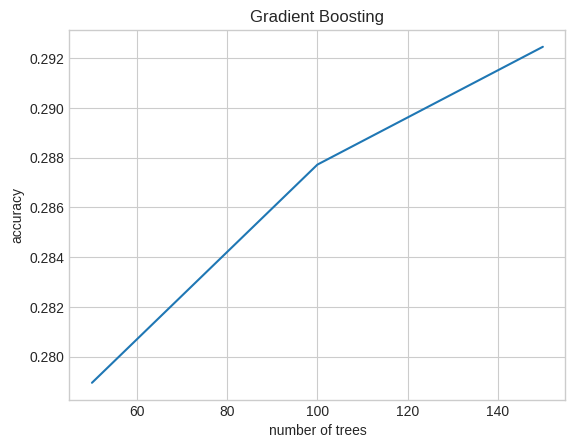

In [ ]:
# Plot der die Accuracy von Gradient Boosting zeigt. Alle Dimensionen in einem Plot

for i, elem in enumerate(scores_gb):
    plt.plot(n_estimators_gb, elem, label=dims[i])
plt.xlabel("number of trees")
plt.ylabel("accuracy")
plt.title("Gradient Boosting")
plt.show()

Auch Decision Trees und die Ensemble Verfahren liefern schlechte Ergebnisse. Aufgrund der enttäuschenden Ergebnisse der einfachen Decision Trees standen die Chancen für ein gutes Ergebnis mit den Ensemble bzw. Boosting-Verfahren schlecht. Diese Vorahnung hat sich bestätigt. Im Allgemeinen kann (sollte) man keine Bäume für diese Anwendung verwenden.

Letzte Hoffnung: Versuch im Kompressionsraum FFNN anzuwenden

In [ ]:
from tensorflow import keras
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [ ]:
# Aufteilen der jeweiligen Daten Trainings- und Testdaten

X_trains = []
X_tests = []
y_trains = []
y_tests = []

y_categorical = to_categorical(y)

for i in range(len(dims)):
    X_train, X_test, y_train, y_test = train_test_split(X_pca[i], y_categorical, test_size=0.2)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

In [ ]:
# Verwenden der PlotLosses Klasse aus Practice 10 (um die Accuracies erweitert)

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('categorical_accuracy'))
        self.val_accuracy.append(logs.get('val_categorical_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

In [ ]:
# Funktion um ein einfaches Netz zu erstellen, das dann kompiliert und trainiert wird

def build_model(i):
    model = keras.Sequential()

    model.add(Dense(64, activation="relu", input_shape=(dims[i],)))
    model.add(Dense(64, activation="relu")),
    model.add(Dense(19, activation="softmax")),

    # Modell kompilieren
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=[keras.metrics.CategoricalAccuracy()])

    # Modell trainieren
    model.fit(X_trains[i], y_trains[i],
              validation_data=(X_tests[i], y_tests[i]), 
              epochs=100,
              batch_size=32,
              verbose=1,
              callbacks=[plot_losses])

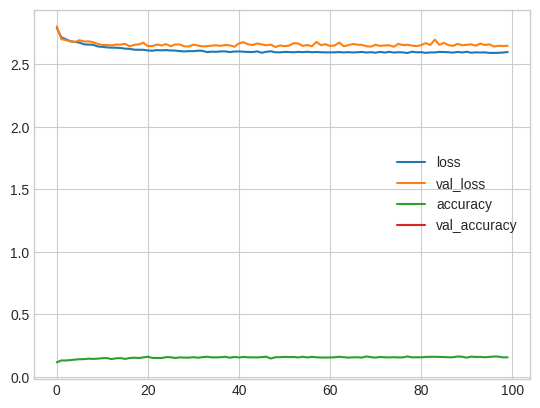

143/143 [==============================] - 0s 3ms/step - loss: 2.5989 - categorical_accuracy: 0.1566 - val_loss: 2.6482 - val_categorical_accuracy: 0.1518


In [ ]:
# NN auf Kompressionsraum mit 1 Dimension

build_model(0)

Modell konvergiert schon nach wenigen Epochen. Einfach zu wenig Information um eine vernünftige Aussage zu treffen. Das Netz ist auch zu groß, da nur ein Input existiert kann das Netz nicht voll genutzt werden.

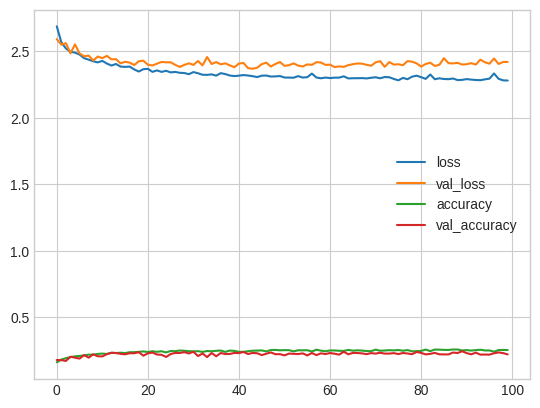

143/143 [==============================] - 0s 3ms/step - loss: 2.2809 - categorical_accuracy: 0.2539 - val_loss: 2.4210 - val_categorical_accuracy: 0.2211


In [ ]:
# NN auf Kompressionsraum mit 2 Dimension

build_model(1)

Gleiches gilt hier. Die Ergebnisse sind ein wenig besser aber immer noch unbrauchbar.

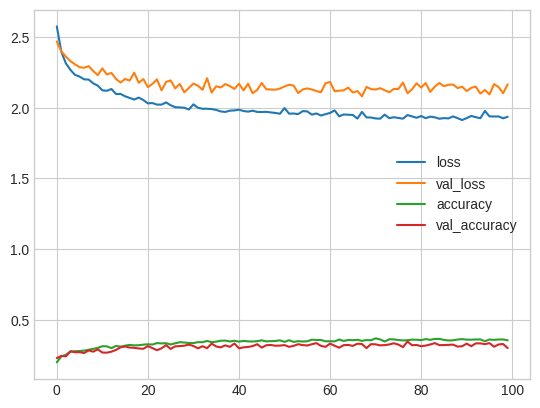

143/143 [==============================] - 0s 3ms/step - loss: 1.9354 - categorical_accuracy: 0.3539 - val_loss: 2.1651 - val_categorical_accuracy: 0.2991


In [ ]:
# NN auf Kompressionsraum mit 3 Dimension

build_model(2)

Langsamere Konvergenz mit besserer Accuracy. Immer noch enttäuschend.

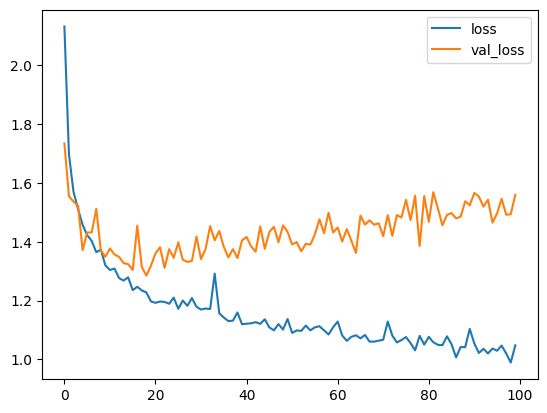

143/143 [==============================] - 0s 3ms/step - loss: 1.0478 - categorical_accuracy: 0.6248 - val_loss: 1.5591 - val_categorical_accuracy: 0.5526


In [ ]:
# NN auf Kompressionsraum mit 5 Dimension

build_model(3)

Erste Anzeichen von Overfitting nach ca. 20 Epochen. Bisher bestes Ergebnis in 5 Dimensionen.

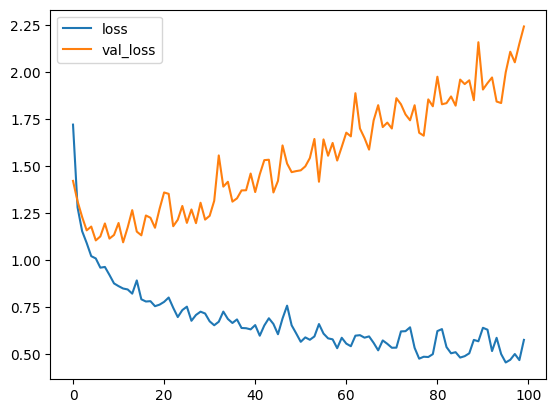

143/143 [==============================] - 0s 3ms/step - loss: 0.5747 - categorical_accuracy: 0.8024 - val_loss: 2.2441 - val_categorical_accuracy: 0.6377


In [ ]:
# NN auf Kompressionsraum mit 10 Dimension

build_model(4)

Sehr starkes Overfitting nach nur wenigen Epochen. Accuracy steigt weiter.

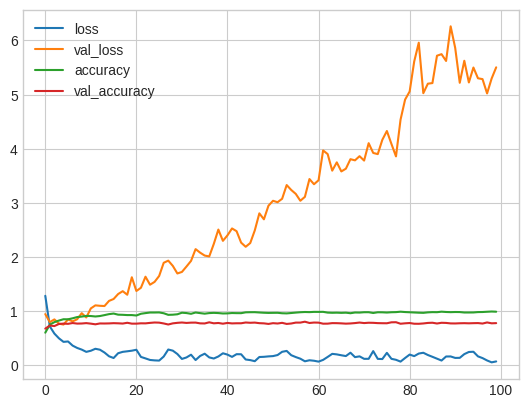

143/143 [==============================] - 1s 5ms/step - loss: 0.0683 - categorical_accuracy: 0.9873 - val_loss: 5.5031 - val_categorical_accuracy: 0.7763


In [ ]:
# NN auf Kompressionsraum mit 100 Dimension

build_model(5)

Overfitting nach nur 5 Dimensionen. Aber erstmalig brauchbare Ergebnisse mit Test-Accuracy von knapp 80 %. Wichtig hierbei ist das Modell mit dem geringsten Testfehler zu verwenden. Obwohl die Test-Accuracy nicht mehr sinkt, steigt der Testfehler nach 5 Epochen stark an. Mit Early-Stopping kann man das beste Modell dann Wiederherstellen oder man overfittet das Modell und trainiert dann nochmal mit der besten Anzahl an Epochen.

Ergebnis: Auch neuronale Netze erreichen nur schlechte Ergebnisse, wenn die Daten nicht sauber trennbar sind. Erst mit weit über 10 bis 100 Dimensionen kann ein ordentliches Ergebnis erzielt werden. Je mehr Dimesionen verfügbar, desto schneller overfitted das Model. Bei 100 Dimensionen schon nach ca. 5 Epochen maximale Testgenauigkeit erreicht während der Testfehler danach immer größer wird.

Die Ergebnisse sind allgemein für die niederdimensionalen Kompressionsräume sehr schlecht und praktisch nicht einsetzbar. Mit mehr Dimensionen steigt die erklärte Varianz und somit auch die Ergebnisse der Verfahren. Das eigentliche Ziel, eine relativ einfache Klassifikation in visualisierbaren Kompressionsräumen (bis 3 Dimensionen) durchzuführen ist mit PCA nicht ausführbar.